# Unsupervised ML: High Value Customers Identification


Customer segmentation is a classical clustering problem. Companies want to divide customers into groups that have similar purchase behaviors to better promote their products, increase customer retention, and maximize benefits for the business<sup>1</sup>.

In this project, I will use the [High-Value Customers Identification](https://www.kaggle.com/vik2012kvs/high-value-customers-identification) dataset from Kaggle. The dataset contains sales data from a UK-based online retail company over the period of November 2016 to December 2017. The goal of the project is to separate customers into groups and identify the group of high-value customers--those who are loyal to the brand and really spend money. Since the customers are not labeled and we do not even know what is the correct number of clusters for this dataset, this is an unsupervised machine learning task.

This project is a revision of hw2. I will use **KMeans** to segment customers into clusters. I will use **elbowology** to choose the best number of clusters and will compare **efficacy** of my own **"cold" implementation of KMeans** and **the KMeans algorithm from sklearn**.

In [1]:
# import block
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans
from scipy.spatial import distance

import time
import memory_profiler

from coding_1 import *

## 1. The Dataset

The dataset has 541909 rows where each row contains 9 variables about one specific transaction, and I will focus on 4 of them: `CustomerID`, `Quantity`, `UnitPrice`, and `Country`.

In [2]:
# import data
records = pd.read_csv("Ecommerce.csv")
print("shape of records is", records.shape)
records.head()

shape of records is (541909, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


I will need to process the dataset so that, in the resulting dataset (the input dataset my model will train on), each row represents a customer. For each customer, I will sum up these three pieces of information:

1. the total amount of money spent by the customer (`Revenue`)
2. the total quantity of products bought by the customer (`Quantity`)
3. the country where the customer is from (`Country`)

In processing the dataset, I will ignore rows where at least one of `Quantity`, `UnitPrice`, and `Country` variables is missing. I will multiple `Quantity` and `UnitPrice` to get the value of a transaction.

In [4]:
# focus on "CustomerID", "Quantity", "UnitPrice", and "Country"
# drop lines with NaN values
records_small = records[["CustomerID", "Quantity", "UnitPrice", "Country"]].dropna()
records_small["CustomerID"] = records_small["CustomerID"].astype(int)

# calculate total revenue for each invoice
records_small["Revenue"] = records_small["Quantity"] * records_small["UnitPrice"]
records_small

# convert the country column to numerical
records_small["Country"] = pd.Categorical(records_small["Country"])
records_small["Country"] = records_small["Country"].cat.codes

print("shape of records_small is", records_small.shape)
records_small.head()

shape of records_small is (406829, 5)


,CustomerID,Quantity,UnitPrice,Country,Revenue
0,17850,6,2.55,35,15.30
1,17850,6,3.39,35,20.34
2,17850,8,2.75,35,22.00
3,17850,6,3.39,35,20.34
4,17850,6,3.39,35,20.34


Then, I will group the dataset by `CustomerID` and sum up the total amount of spending (`Revenue`) and total quantity (`Quantity`) for each customer. I will convert the categorical `Country` variable to numerical, each country having a unique code.

In [5]:
# get the total money each customer spent and the total quantity each customer bought

# code consultation:
# https://stackoverflow.com/questions/49783178/python-keep-other-columns-when-using-sum-with-groupby

customer = records_small.groupby(["CustomerID"], as_index=False)['Quantity', 'Revenue', 'Country'].agg({'Quantity': 'sum', 'Revenue': 'sum', 'Country': 'first'})
print("shape of customer is", customer.shape)
customer.head(10)

shape of customer is (4372, 4)


<ipython-input-5-fbb3e53cfdb6>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  customer = records_small.groupby(["CustomerID"], as_index=False)['Quantity', 'Revenue', 'Country'].agg({'Quantity': 'sum', 'Revenue': 'sum', 'Country': 'first'})


,CustomerID,Quantity,Revenue,Country
0,12346,0,0.00,35
1,12347,2458,4310.00,16
2,12348,2341,1797.24,12
3,12349,631,1757.55,18
4,12350,197,334.40,24
5,12352,470,1545.41,24
6,12353,20,89.00,2
7,12354,530,1079.40,30
8,12355,240,459.40,2
9,12356,1591,2811.43,26


In [6]:
# convert the dataset to a numpy array for later use
customer_np = customer[['Quantity', 'Revenue', 'Country']].to_numpy()
customer_np

array([[   0.  ,    0.  ,   35.  ],
       [2458.  , 4310.  ,   16.  ],
       [2341.  , 1797.24,   12.  ],
       ...,
       [  98.  ,  176.6 ,   35.  ],
       [1397.  , 2094.88,   35.  ],
       [1586.  , 1837.28,   35.  ]])

## 2. Looping KMeans and Efficacy Comparison

The hyperparameter here is k, the number of clusters. I will use **elbowology** to find the best k. I also want to compare the efficacy of my KMeans implementation and that of sklearn's KMeans implementation. Therefore, I will implement a looping-KMeans (k=2 to k=15) first with my KMeans and then with sklearn's KMeans and compare the runtime and memory usage.

### 2.1. Time

In [7]:
start_time = time.time()

# looping k-means with implementation from sklearn
SSE_list_sklearn = looping_kmeans_sklearn(customer_np, range(2, 16))

# Stop the clock and determine the length of time
stop_time = time.time()

print("This took %s seconds to run" % (stop_time - start_time))

This took 8.021277904510498 seconds to run


In [8]:
start_time = time.time()

# looping k-means with my implementation of KMeans
SSE_list_my_kmeans = looping_kmeans_my(customer_np, range(2, 16))

# Stop the clock and determine the length of time
stop_time = time.time()

print("This took %s seconds to run" % (stop_time - start_time))

This took 50.782066106796265 seconds to run


It took 8.021 seconds to run a looping KMeans with sklearn's KMeans, and 50.782 seconds with my KMeans. It took significantly longer time to run my KMeans, which is surprising to me. In lab 18, I have timed my KMeans and sklearn's KMeans on the student_info dataset, and my KMeans took slightly shorter time than sklearn's KMeans did. I guess one reason to explain the opposite results I got is the size of the dataset. The dataset used in this project is significantly larger then the student_info dataset, which may have magnified the inefficient sections in my implementation.


### 2.2. Memory

In [9]:
%load_ext memory_profiler

In [10]:
# sklearn's KMeans
%memit looping_kmeans_sklearn(customer_np, range(2, 16))

peak memory: 229.73 MiB, increment: 0.03 MiB


In [11]:
# My KMeans
%memit looping_kmeans_my(customer_np, range(2, 16))

peak memory: 230.39 MiB, increment: 0.65 MiB


Though the peak memory usage of my KMeans and sklearn's KMeans are about the same, increment of my implementation is significantly larger than that of sklearn's. As stated in [this post](https://stackoverflow.com/questions/45318536/trying-to-understand-python-memory-profiler), "Increment is the increment in memory usage relative to the memory usage just before the program is run." Since my implementation has a larger increment in memory usage, again, my implementation is significantly less efficient than that of sklearn's.


## 3. Elbowology: Choosing the Best k

I have implemented looping KMeans with my KMeans and sklearn's KMeans and got two lists of within-cluster SSE. I plot the within-cluster SSE over the number of clusters and got the plot below.

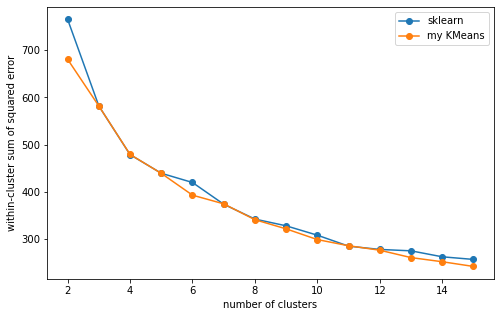

In [12]:
# plot within-cluster SSE over number of clusters
plt.figure(figsize=(8,5))
plt.plot(range(2, 16), SSE_list_sklearn, '-o', label='sklearn')
plt.plot(range(2, 16), SSE_list_my_kmeans, '-o', label='my KMeans')
plt.xlabel('number of clusters')
plt.ylabel('within-cluster sum of squared error')
plt.legend()
plt.show()

The "elbow" is not that obvious in the plot above. However, there seems to be a slight "elbow" at k=4 for both lines. Therefore, I decide the best number of clusters is 4.


## 4. Modeling and Interpretation

I plot `Quantity` over label, `Revenue` over label, and `Country` over label and got the plots below.

In [13]:
km_model = KMeans(n_clusters=4)
km_model.fit(customer_np)

customer['Label'] = km_model.predict(customer_np)
customer.head()

,CustomerID,Quantity,Revenue,Country,Label
0,12346,0,0.00,35,0
1,12347,2458,4310.00,16,0
2,12348,2341,1797.24,12,0
3,12349,631,1757.55,18,0
4,12350,197,334.40,24,0


<AxesSubplot:xlabel='Label', ylabel='Quantity'>

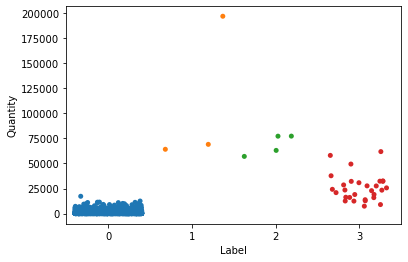

In [16]:
sns.stripplot(x='Label', y='Quantity', data=customer, jitter=0.4)

<AxesSubplot:xlabel='Label', ylabel='Revenue'>

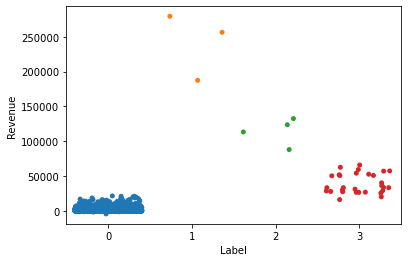

In [17]:
sns.stripplot(x='Label', y='Revenue', data=customer, jitter=0.4)

<AxesSubplot:xlabel='Label', ylabel='Country'>

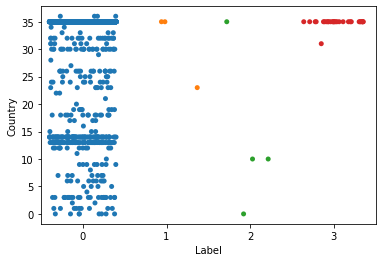

In [18]:
sns.stripplot(x='Label', y='Country', data=customer, jitter=0.4)

Since there are few points in class 2 and 3 and that those points have uncommonly high `Quantity` and `Revenue`, my guess is that those are outliers. Looking at group 1 and group 4, my observations are:

* in general, data points in group 4 have higher `Quantity` than those in group 1
* in general, data points in group 4 have higher `Revenue` than those in group 1
* in general, customers in group 4 are from the UK (country code 35)

My conclusion is that customers in group 4 are the high-value customers we are finding, since they have bought more products and spent more money. It is more likely that high-value customers are from the UK, which makes sense since the base of the business is in the UK.